<a href="https://colab.research.google.com/github/ElijahMorales04/reu-tribolium-modeling/blob/main/FEM_Simulation_Tribolium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

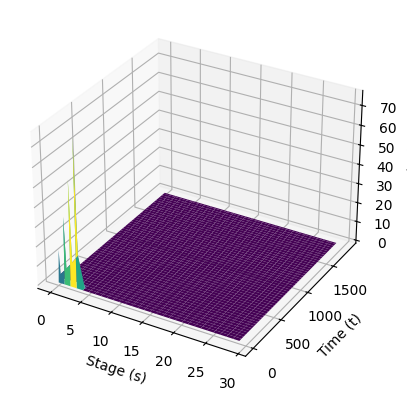

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.sparse import diags
import plotly.graph_objects as go

# parameters
g = 1
c_ea = 0.0003 / 14
c_el = 0.0179 / 14
c_pa = 0
b = 20 / 14
mu_l = 0.6053
mu_a = 0.0842
s1, s2, s3 = 3, 14, 29          # stage boundaries (days)

# stage grid
ds = 1
s = np.arange(0, s3 + 1, ds)
idx_s1, idx_s2, idx_s3 = int(s1 / ds), int(s2 / ds), int(s3 / ds)
n1, n2, n3 = idx_s1 + 1, idx_s2 - idx_s1, idx_s3 - idx_s2     # eggs, larvae, pupae

def mass_stiff(n):
    return np.eye(n), diags([-1, 1], [-1, 0], shape=(n, n)).toarray()

M1, K1 = mass_stiff(n1)
M2, K2 = mass_stiff(n2)
M3, K3 = mass_stiff(n3)

def model(t, y):
    p1  = y[:n1]
    p2  = y[n1:n1 + n2]
    p3  = y[n1 + n2:n1 + n2 + n3]
    A   = y[-1]

    I1  = p2.sum()

    dp1 = -g * (K1 @ p1) - c_ea * A - c_el * I1 + b * A
    dp2 = -g * (K2 @ p2) - mu_l * p2
    dp3 = -g * (K3 @ p3) - c_pa * A
    dA  = g * p3[-1] - mu_a * A

    return np.concatenate([dp1, dp2, dp3, [dA]])

# initial state
y0 = np.zeros(n1 + n2 + n3 + 1)
y0[-1] = 50

t_span = (0, 1826)
t_eval = np.linspace(*t_span, 100)
sol = solve_ivp(model, t_span, y0, t_eval=t_eval)

# surface plot (Matplotlib)
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
S, T = np.meshgrid(s, sol.t)
ax.plot_surface(S, T, sol.y[:-1].T, cmap="viridis")
ax.set_xlabel("Stage (s)")
ax.set_ylabel("Time (t)")
ax.set_zlabel("p(s, t)")
plt.show()

# surface plot (Plotly, interactive)
fig = go.Figure(data=[go.Surface(z=sol.y[:-1], x=s, y=sol.t)])
fig.update_layout(scene=dict(xaxis_title="Stage", yaxis_title="Time", zaxis_title="p(s,t)"),
                  width=800, height=800)
fig.show()